<a href="https://colab.research.google.com/github/evpozdniakov/ds_projects/blob/master/project4/bank_deposit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект: классификация

In [420]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from collections import Counter
import optuna
from sklearn.model_selection import cross_val_score

### Вспомогательные функции

In [329]:
def figax(name, figsize=(7, 4), rowcol=None, axes=[0,0,1,1]):
    fig = plt.figure(name, figsize=figsize)

    if rowcol is None:
        ax = fig.add_axes(axes)
    else:
        rows, cols = rowcol
        ax = fig.subplots(rows, cols)

    return fig, ax

def remove_extremes_with_tukey(df, feature_name, inplace=False):
    feature_data = df[feature_name]

    Q1 = feature_data.quantile(0.25)
    Q3 = feature_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    m1 = feature_data < lower_bound
    m2 = feature_data > upper_bound

    if inplace:
        df.drop(index=df[m1 | m2].index, inplace=inplace)
    else:
        return df.drop(index=df[m1 | m2].index)

def draw_boxplot(df, feature_name, title='', log=False):
    _fig, ax = figax(feature_name, figsize=(6, 1))
    sns.boxplot(ax=ax, data=df, x=feature_name, palette='pastel')
    ax.set_title(title if title != '' else feature_name, fontsize=10)
    ax.set_xlabel('')

    if log:
        ax.set_xscale('log')

def draw_histplot(df, feature_name, title='', log=False, histplot_kwargs={}):
    _fig, ax = figax(feature_name)
    color = sns.color_palette('pastel')[0]
    sns.histplot(ax=ax, data=df[feature_name], color=color, **histplot_kwargs)
    ax.set_title(title if title != '' else feature_name, fontsize=10)
    ax.set_xlabel('')

    if log:
        ax.set_xscale('log')

def draw_feature_diagram(df, feature_title, ax):
    feature_name = feature_title[0]
    value_counts = df[feature_name].value_counts()
    
    ax.pie(
        value_counts,
        labels=value_counts.index,
        # autopct='%1.1f%%',
        textprops={'fontsize': 8},
        # startangle=90,
        colors = sns.color_palette("pastel")
    )

    title = feature_title[1]
    ax.set_title(title, fontsize=10);

def draw_feature_diagram_pair(df, feature_title_l, feature_title_r):
    _fig, ax = figax('diagram_pair', figsize=(12, 4), rowcol=(1, 2))
    draw_feature_diagram(df, feature_title_l, ax[0])
    draw_feature_diagram(df, feature_title_r, ax[1])

def apply_label_encoder(data, columns, encoder=None):
    if encoder is None:
        encoder = preprocessing.LabelEncoder()

    data.loc[:, columns] = encoder.fit_transform(data[columns])

    return encoder

def visualize_numeric_columns_importance(data, target_column, figsize=(10, 10), title=None):
    data = data.copy()
    X = data.drop(columns=[target_column])
    y = data[target_column]

    num_cols = X.select_dtypes(include='number').columns

    f_classif_results = f_classif(X[num_cols], y)

    data = pd.DataFrame(data=f_classif_results[0], index=num_cols, columns=['value'])
    data.sort_values(by=['value'], inplace=True, ascending=False)

    _fig, ax = figax('importance', figsize=figsize)
    sns.barplot(ax=ax, data=data, x='value', y=data.index);

    if title is not None:
        ax.set_title(title);


## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [255]:
df = pd.read_csv('data/bank_fin.zip', sep = ';')

In [256]:
# Данные загружены, посмотрим на них:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [257]:
# Сохраним исходные данные в `df_orig` на всякий случай:
df_orig = df.copy()

In [258]:
df = df_orig.copy()

In [259]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код

# Для начала воспользуемся командой `info`:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [260]:
# Мы можем видеть что небольшое кол-во пропусков есть в признаке `balance`.

# Напишем другую команду, чтобы увидеть только кол-во пропусков
# для всех признаков (вдруг мы что-то просмотрели в выводе выше):
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [261]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?

# Выведем все уникальные значения признака `job`:
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

In [262]:
# Видим, что значение `unknown` в признаке `job` используется для обозначения пропусков.

# Проверим, сколько таких пропусков имеется в наших данных:
m = df['job'] == 'unknown'
m.sum()

70

### Задание 3

In [263]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

# Выведем несколько значений признака:
df['balance'].head(15)

0      2 343,00 $ 
1         45,00 $ 
2      1 270,00 $ 
3      2 476,00 $ 
4        184,00 $ 
5            0  $ 
6        830,00 $ 
7        545,00 $ 
8          1,00 $ 
9              NaN
10       100,00 $ 
11       309,00 $ 
12       199,00 $ 
13       460,00 $ 
14       703,00 $ 
Name: balance, dtype: object

In [264]:
# Напишем функцию для преобразования таких данных в число типа float
def balance_to_float(balance):
    if type(balance) != str:
        return balance

    balance = balance.replace(" ", "").replace(",", ".").replace("$", "")
    return float(balance)

# Проверим как она работает
balance_15 = df['balance'][0:15]
[(x, balance_to_float(x)) for x in balance_15]

[(' 2 343,00 $ ', 2343.0),
 (' 45,00 $ ', 45.0),
 (' 1 270,00 $ ', 1270.0),
 (' 2 476,00 $ ', 2476.0),
 (' 184,00 $ ', 184.0),
 ('0  $ ', 0.0),
 (' 830,00 $ ', 830.0),
 (' 545,00 $ ', 545.0),
 (' 1,00 $ ', 1.0),
 (nan, nan),
 (' 100,00 $ ', 100.0),
 (' 309,00 $ ', 309.0),
 (' 199,00 $ ', 199.0),
 (' 460,00 $ ', 460.0),
 (' 703,00 $ ', 703.0)]

In [265]:
# Теперь применим функцию и преобразуем данные признака:
df.loc[:, 'balance'] = df['balance'].apply(balance_to_float)

# Посмотрим, что получилось:
df['balance']

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

### Задание 4

In [266]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код

# Воспользуемся методом `fillna`:
df['balance'].fillna(df['balance'].median(), inplace=True)

# Убедимся, что пропусков не осталось:
df['balance'].isna().sum()

0

### Задание 5

In [267]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код

# Посмотрим, какое слово используется для обозначения пропусков в признаке `education`:
df['education'].unique()

array(['secondary', 'tertiary', 'primary', 'unknown'], dtype=object)

In [268]:
# Заменим `unknown` на `NaN` в обоих признаках:
m = df['education'] == 'unknown'
df.loc[m, 'education'] = np.nan

m = df['job'] == 'unknown'
df.loc[m, 'job'] = np.nan

# Убедимся, что в этих признаках появились пропуски
df.isna().sum()

age            0
job           70
marital        0
education    497
default        0
balance        0
housing        0
loan           0
contact        0
day            0
month          0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
deposit        0
dtype: int64

In [269]:
# Заменим пропуски на модальные значения с помощью `fillna`:
df.fillna({
    'job': df['job'].mode()[0],
    'education': df['education'].mode()[0],
}, inplace=True)

# Убедимся, что в этих признаках пропуски исчезли:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [270]:
# Задание 2.5
# После замены пропусков рассчитайте средний баланс для клиентов 
# с самой популярной работой и самым популярным уровнем образования 
# (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование).
# Ответ округлите до трёх знаков после точки-разделителя.

m1 = df['education'] == df['education'].mode()[0]
m2 = df['job'] == df['job'].mode()[0]

round(df[m1 & m2]['balance'].mean(), 3)

1598.883

### Задание 6

<AxesSubplot: >

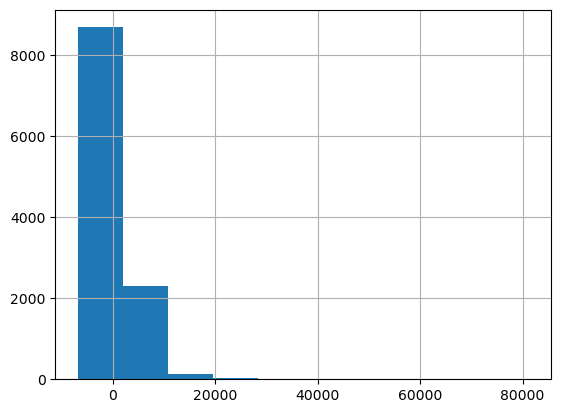

In [271]:
# удалите все выбросы для признака balance
# ваш код

# Построим гистограмму распределения значений:
df['balance'].hist()

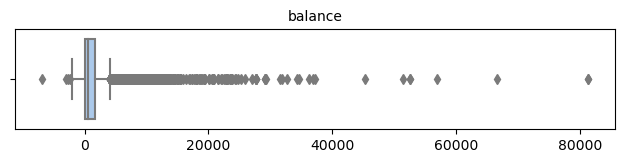

In [272]:
# Гистограмма показывает, что у нас есть много отрицательных значений,
# а также некоторое кол-во чересчур больших значений.

# Для лучшей наглядности построим коробчатую диаграмму.

draw_boxplot(df, 'balance')


In [273]:
# Задание 2.6
# Введите верхнюю и нижнюю границы поиска выбросов по методу Тьюки, округлив их до целых чисел.

feature_data = df['balance']

Q1 = feature_data.quantile(0.25)
Q3 = feature_data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f'нижняя граница: {round(lower_bound)}')
print(f'верхняя граница: {round(upper_bound)}')

нижняя граница: -2241
верхняя граница: 4063


In [274]:
# Уберем выбросы с помощью метода Тьюки
# и посмотрим сколько значений осталось
remove_extremes_with_tukey(df, 'balance', inplace=True)
df.shape[0]

10105

## Часть 2:  Разведывательный анализ

### Задание 1

In [275]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код

df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

In [276]:
# Видим примерно одинаковое кол-во ответов `yes` и `no`.
# Посмотрим чему равно соотношение в процентах:
df['deposit'].value_counts(normalize=True) * 100

no     53.676398
yes    46.323602
Name: deposit, dtype: float64

### Задания 2 и 3

In [277]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

# Для начала воспользуемся методом `describe`
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


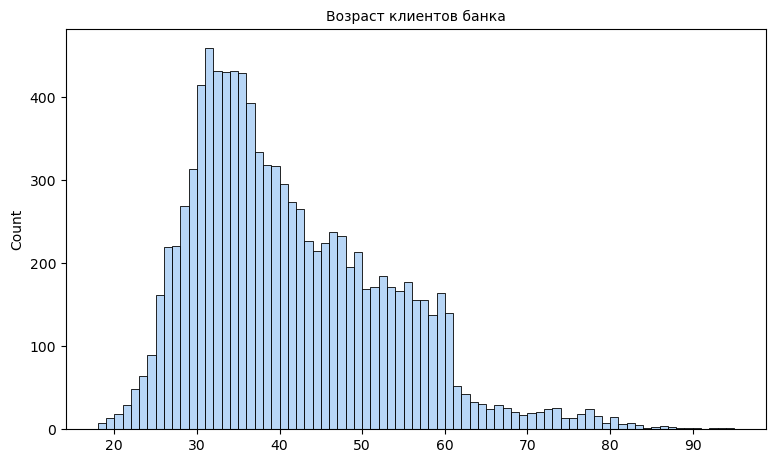

In [278]:
# Данные в признаке `age` распределены лог-нормально.
# Самому младшему клиенту банка 18 лет, самому старшему 95.
# Медианный возраст 38 лет, средний 41.
# Нам следует разделить клиентов на несколько возрастных категорий,
# например до 30, 30-40, 41-50, 51-60 и старше 60

# Посмотрим на гистограмму:
draw_histplot(df, 'age', title='Возраст клиентов банка', histplot_kwargs={
    'binwidth': 1,
})

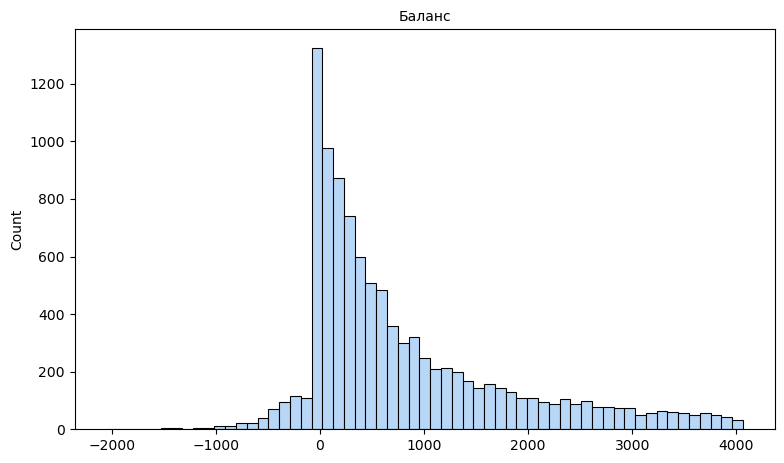

In [279]:
# Данные в признаке `balance` распределены лог-нормально.
# Наименьший баланс -2049$, наибольший 4063$, медианный 445$
# Часть клиентов имеют отрицательный баланс. Нам следует
# выделить их в отдельную категорию. Также в отдельную категорию
# следует выделить клиентов с нулевым балансом, и добавить
# несколько категорий для всех остальных клиентов, например:
# до 100$, от 100 до 500$, от 500$ до 1000$, больше 1000$

# Посмотрим на гистограмму:
draw_histplot(df, 'balance', title='Баланс')

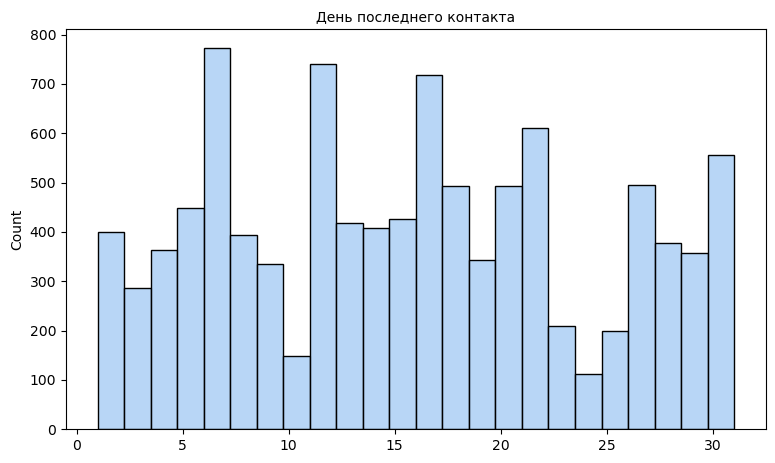

In [280]:
# Данные в признаке `day` распределены более-менее равномерно.
# Сам по себе этот признак не несет полезной информации.
# Но если его рассматривать вместе с месяцем и годом, то можно
# было бы определить день недели, а также был ли этот день будним
# или праздничным.

# Посмотрим на гистограмму:
draw_histplot(df, 'day', title='День последнего контакта')

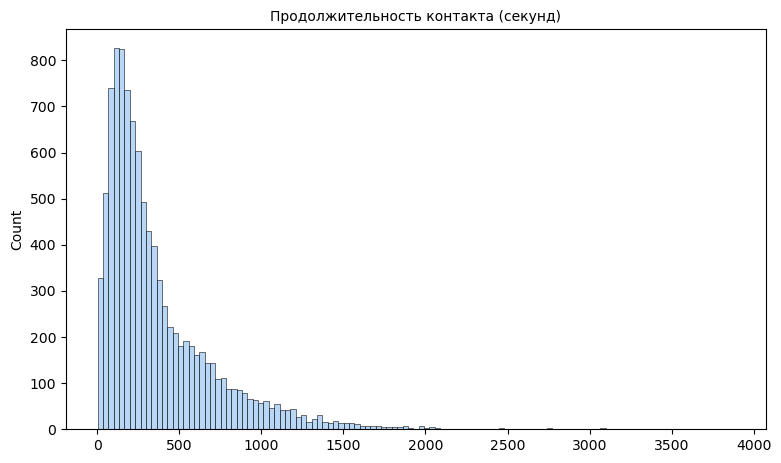

In [281]:
# Данные в `duration` распределены логнормально.
# Есть некоторое кол-во слишком коротких контактов,
# их следует выделить в отдельную категорию.
# Остальные контакты можно также распределить по категориям,
# например до 10 секунд (слишком короткие), от 10 секунд до минуты,
# от 1 до 3 минут, от 3 до 8 минут, от 8 до 13 минут, больше 13 минут.

# Посмотрим на гистограмму:
draw_histplot(df, 'duration', title='Продолжительность контакта (секунд)')

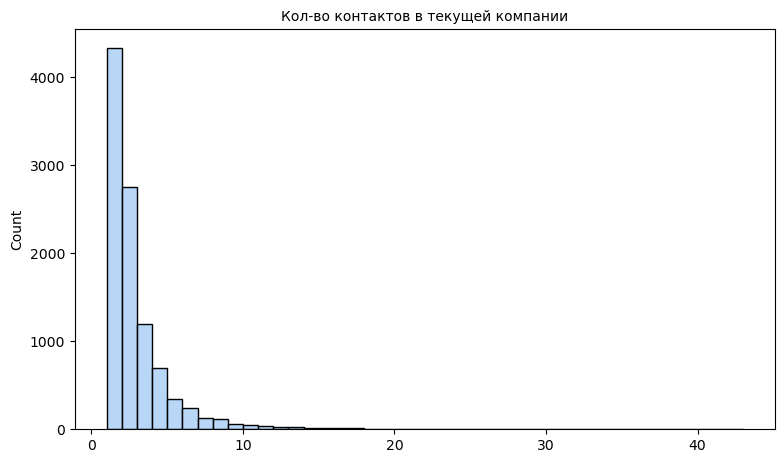

In [282]:
# Данные в `campaign` распределены обратно экспоненциально.
# Большинство значений в этом признаке равны 1, 2 и 3.
# Есть несколько клиентов, с которыми контакировали аномально
# часто, 20 и более раз. Следует подумать о том, чтобы исключить
# такие данные из выборки или выделить в отдельную категорию.
# Остальные данные имеет смысл разбить на следующие категории:
# 1 контакт, 2 контакта, 3-6 контактов, больше 6 контактов

draw_histplot(df, 'campaign', title='Кол-во контактов в текущей компании', histplot_kwargs={
    'binwidth': 1
})

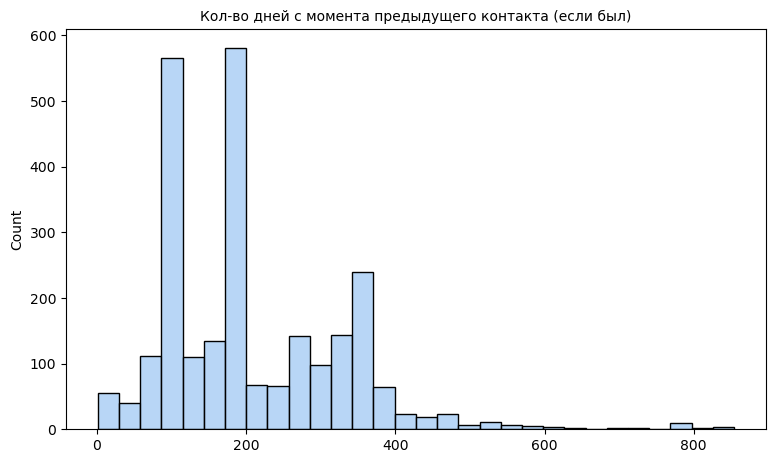

In [283]:
# В признаке `pdays` содержится кол-во дней между контактами в текущей маркетинговой
# кампании и предыдущей. В случае, если с клиентом не контактировали ранее, в качестве
# значения в данном признаке указано -1. И таких значений в признаке большинство.
# Остальные значения изменяются от 1 до 854. Мы можем видеть три пика, которые приходятся 
# на крупные маркетинговые кампании. Учитывая это, мы можем разбить данные в признаке 
# на пять категорий: предыдущих контактов не было, от 0 до 100 дней, от 100 до 200 дней,
# от 200 до 400 дней, больше 400 дней с момента предыдущего контакта.

m = df['pdays'] >= 0

draw_histplot(df[m], 'pdays', title='Кол-во дней с момента предыдущего контакта (если был)')

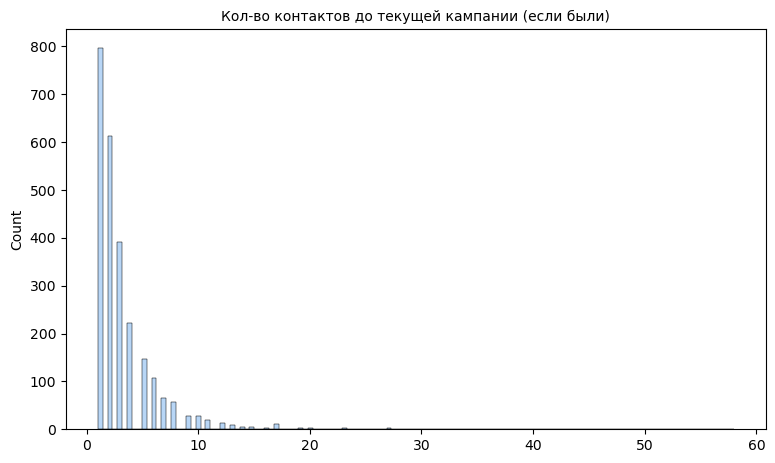

In [284]:
# В признаке `previous` содерижтся кол-во контактов до текущей кампании.
# Большинство значений в признаке (примерно 3/4) равны нулю. (Это значит,
# что с большинтсвом клиентов в выборке не было контактов до текущей
# маркетинговой кампании.) Остальные значения изменяются от 1 до 58 
# и распределены обратно экспоненциально. Мы можем разделить значения
# на следующие группы по кол-ву контактов: 0, 1, 2, 3-5, 6-10, больше 10

m = df['previous'] > 0

draw_histplot(df[m], 'previous', title='Кол-во контактов до текущей кампании (если были)')

### Задания 4 и 5

In [285]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#постройте визуализации, иллюстрирующие результаты

# Для начала воспользуемся методом `describe`
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


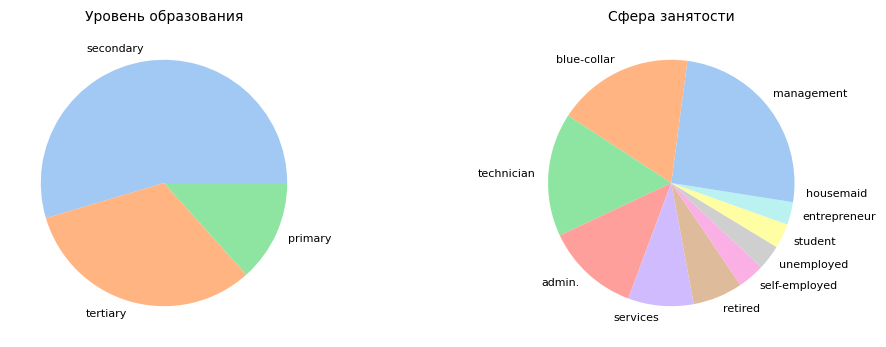

In [286]:
# Видим, что в большинстве категорий кол-во уникальных значений 2 и 3.
# Построим диаграммы для всех признаков.

# Больше половины клиентов банка имеют среднее оразование, примерно треть
# высшее и примерно одна шестая — только начальное.

# Три четверти клиентов банка составляют менеджеры (23%), рабочие (18%), технические
# специалисты (16%), администраторы (12%) и служащие (9%).

draw_feature_diagram_pair(
    df,
    ('education', 'Уровень образования'),
    ('job', 'Cфера занятости'))

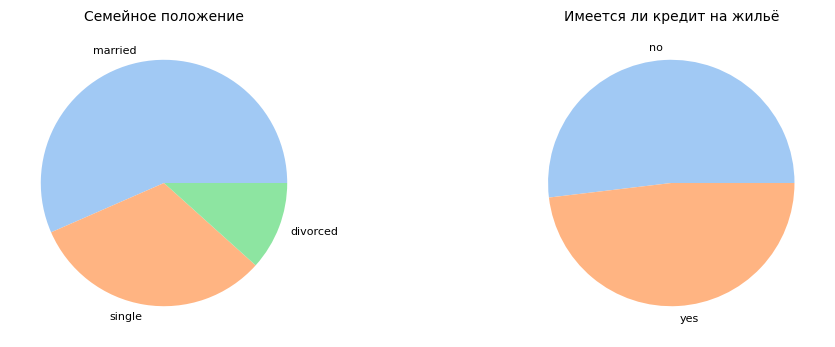

In [287]:
# Больше половины клиентов банка имеют семью, треть — холостяки,
# около 12% разведены.

# Чуть меньше половины клиентов имеют кредит на жилье.

draw_feature_diagram_pair(
    df,
    ('marital', 'Семейное положение'),
    ('housing', 'Имеется ли кредит на жильё'))

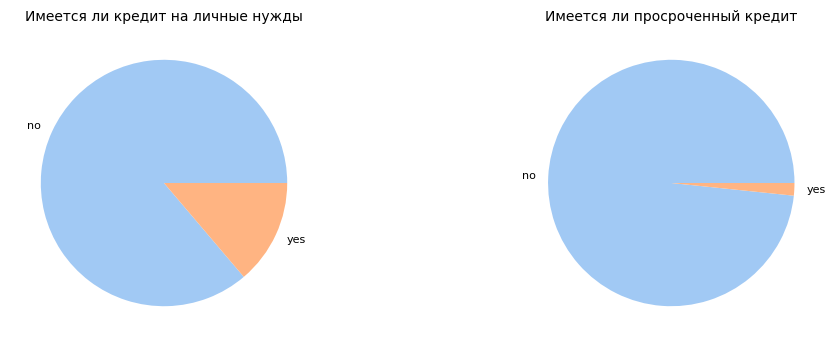

In [288]:
# 14% имеют кредит на личные нужды. Только полтора процента клиентов 
# имеют просроченный кредит.

draw_feature_diagram_pair(
    df,
    ('loan', 'Имеется ли кредит на личные нужды'),
    ('default', 'Имеется ли просроченный кредит'))


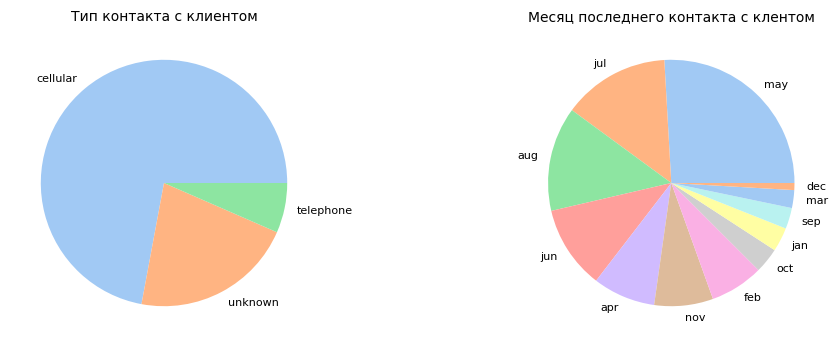

In [289]:
# С большинством клиентов контактировали через мобильный телефон.
# Около 7% звонков были сделаны на домашний телефон.
# Тип связи для примерно пятой части контактов не установлен.

# Чуть больше половины контактов приходится на три месяца:
# май, июль и август, а меньше всего контактов (1%) на декабрь.

draw_feature_diagram_pair(
    df,
    ('contact', 'Тип контакта с клиентом'),
    ('month', 'Месяц последнего контакта с клентом'))


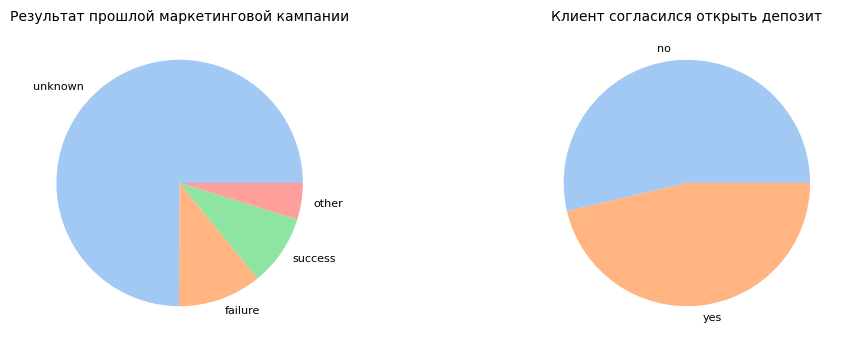

In [290]:
# Только с одной четвертью клиентов представленных в выборке
# контактировали по поводу предыдущей маркетинговой кампании.
# Среди них примерно треть согласилась приобрести продукт или услугу.

# Результат последней маркетинговой кампании более успешный —
# почти половина клиентов (46%) решили приобрести депозит.

draw_feature_diagram_pair(
    df,
    ('poutcome', 'Результат прошлой маркетинговой кампании'),
    ('deposit', 'Клиент согласился открыть депозит'))


### Задание 6

In [291]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании 
# успех в текущей превалирует над количеством неудач.
# ваш код

df2 = df[['poutcome', 'deposit']].copy()
df2.loc[:, 'deposit_flag'] = df2['deposit'] == 'yes'

def print_success_percent_for_prev_status(prev_status):
    m = df2['poutcome'] == prev_status
    percent = round(df2[m]['deposit_flag'].mean() * 100, 2)

    print(f'Доля успеха для статуса "{prev_status}" составляет {percent}%')

print_success_percent_for_prev_status('success')
print_success_percent_for_prev_status('failure')
print_success_percent_for_prev_status('other')

Доля успеха для статуса "success" составляет 91.11%
Доля успеха для статуса "failure" составляет 49.32%
Доля успеха для статуса "other" составляет 55.09%


In [292]:
# types = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
# types.plot(kind='bar', stacked='True')

### Задание 7

In [293]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

df2 = df[['month', 'deposit']].copy()

df2.loc[:, 'deposit_flag'] = df2['deposit'] == 'yes'

deposit_by_month = df2.groupby('month')[['deposit_flag']].mean().sort_values('deposit_flag')

worst_month = deposit_by_month.iloc[0]
best_month = deposit_by_month.iloc[-1]

print(f'Чаще всего отказывались открыть депозит в месяце "{worst_month.name}"')
print(f'Кол-во отказов составило {round(100 * (1 - worst_month.values[0]), 2)}%')
print('')
print(f'Реже всего отказывались открыть депозит в месяце "{best_month.name}"')
print(f'Кол-во отказов составило {round(100 * (1 - best_month.values[0]), 2)}%')


Чаще всего отказывались открыть депозит в месяце "may"
Кол-во отказов составило 67.86%

Реже всего отказывались открыть депозит в месяце "dec"
Кол-во отказов составило 9.68%


In [294]:
df.select_dtypes(include='number').columns.values

array(['age', 'balance', 'day', 'duration', 'campaign', 'pdays',
       'previous'], dtype=object)

### Задание 8

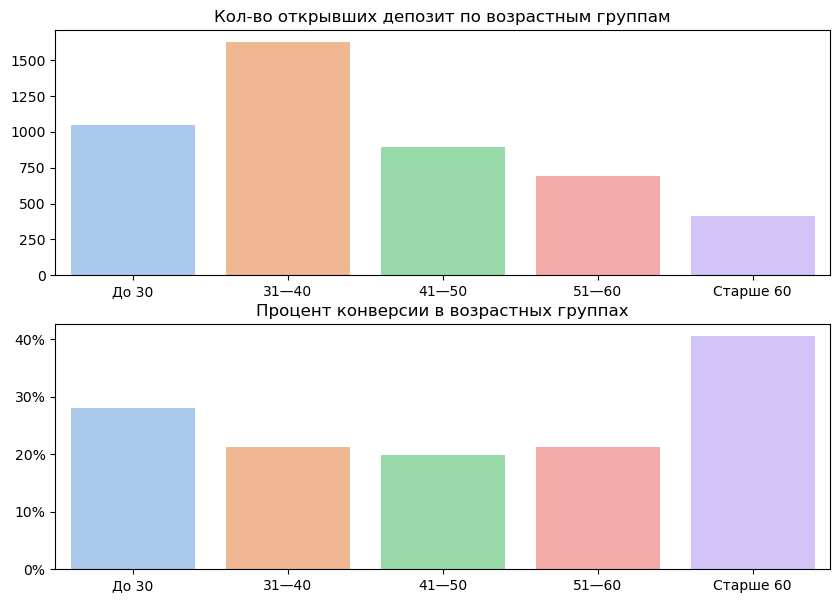

In [311]:
# создайте возрастные группы и определите, в каких группах 
# более склонны открывать депозит, чем отказываться от предложения

def calc_age_group(age):
    if age <= 30: return 1
    if age <= 40: return 2
    if age <= 50: return 3
    if age <= 60: return 4
    return 5

df.loc[:, 'age_group'] = df['age'].apply(calc_age_group)

df['deposit_flag'] = df['deposit'] == 'yes'
data = df.groupby('age_group')['deposit_flag'].agg(['sum', 'count']).reset_index()
data['conversion'] = data['sum'] / data['count']

_fig, ax = figax('by_age_group', rowcol=(2, 1), figsize=(10, 7))

sns.barplot(ax=ax[0], data=data, x='age_group', y='sum', palette='pastel');
ax[0].set_title('Кол-во открывших депозит по возрастным группам');
ax[0].set_ylabel('');
ax[0].set_xlabel('');
ax[0].set_xticklabels([
    'До 30',
    '31—40',
    '41—50',
    '51—60',
    'Старше 60',
]);

sns.barplot(ax=ax[1], data=data, x='age_group', y='conversion', palette='pastel');
ax[1].set_title('Процент конверсии в возрастных группах');
ax[1].set_ylabel('');
ax[1].set_yticklabels([str(x) + '%' for x in range(0, 71, 10)]);
ax[1].set_xlabel('');
ax[1].set_xticklabels([
    'До 30',
    '31—40',
    '41—50',
    '51—60',
    'Старше 60',
]);


### Задания 9 и 10

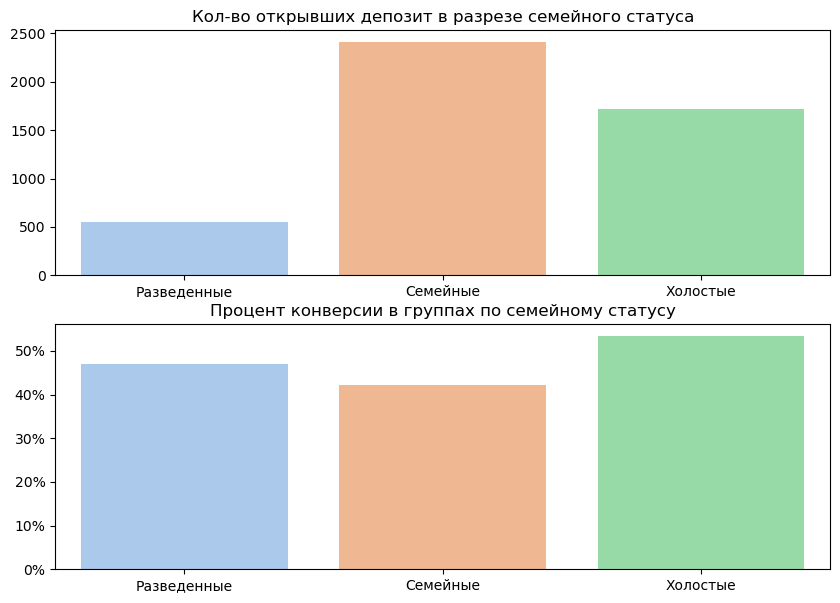

In [313]:
# постройте визуализации для открывших и неоткрывших депозит 
# в зависимости от семейного статуса

data = df.groupby('marital')['deposit_flag'].agg(['sum', 'count']).reset_index()

data['conversion'] = data['sum'] / data['count']

_fig, ax = figax('by_marital', rowcol=(2, 1), figsize=(10, 7))

sns.barplot(ax=ax[0], data=data, x='marital', y='sum', palette='pastel');
ax[0].set_title('Кол-во открывших депозит в разрезе семейного статуса');
ax[0].set_ylabel('');
ax[0].set_xlabel('');
ax[0].set_xticklabels(['Разведенные', 'Семейные', 'Холостые']);

sns.barplot(ax=ax[1], data=data, x='marital', y='conversion', palette='pastel');
ax[1].set_title('Процент конверсии в группах по семейному статусу');
ax[1].set_ylabel('');
ax[1].set_yticklabels([str(x) + '%' for x in range(0, 51, 10)]);
ax[1].set_xlabel('');
ax[1].set_xticklabels(['Разведенные', 'Семейные', 'Холостые']);


In [314]:
# sns.countplot(y='marital', hue='deposit', data=df)

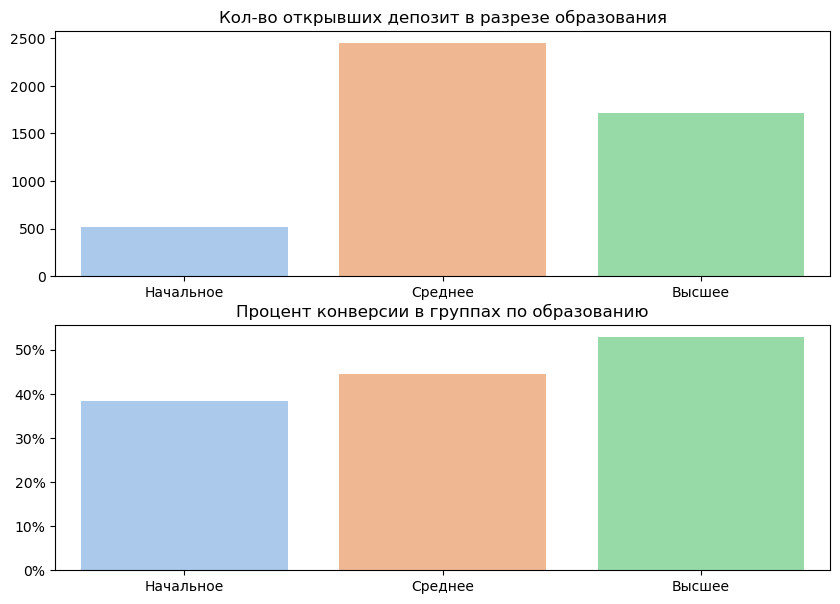

In [315]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

data = df.groupby('education')['deposit_flag'].agg(['sum', 'count']).reset_index()

data['conversion'] = data['sum'] / data['count']

_fig, ax = figax('by_education', rowcol=(2, 1), figsize=(10, 7))

sns.barplot(ax=ax[0], data=data, x='education', y='sum', palette='pastel');
ax[0].set_title('Кол-во открывших депозит в разрезе образования');
ax[0].set_ylabel('');
ax[0].set_xlabel('');
ax[0].set_xticklabels(['Начальное', 'Среднее', 'Высшее']);

sns.barplot(ax=ax[1], data=data, x='education', y='conversion', palette='pastel');
ax[1].set_title('Процент конверсии в группах по образованию');
ax[1].set_ylabel('');
ax[1].set_yticklabels([str(x) + '%' for x in range(0, 51, 10)]);
ax[1].set_xlabel('');
ax[1].set_xticklabels(['Начальное', 'Среднее', 'Высшее']);


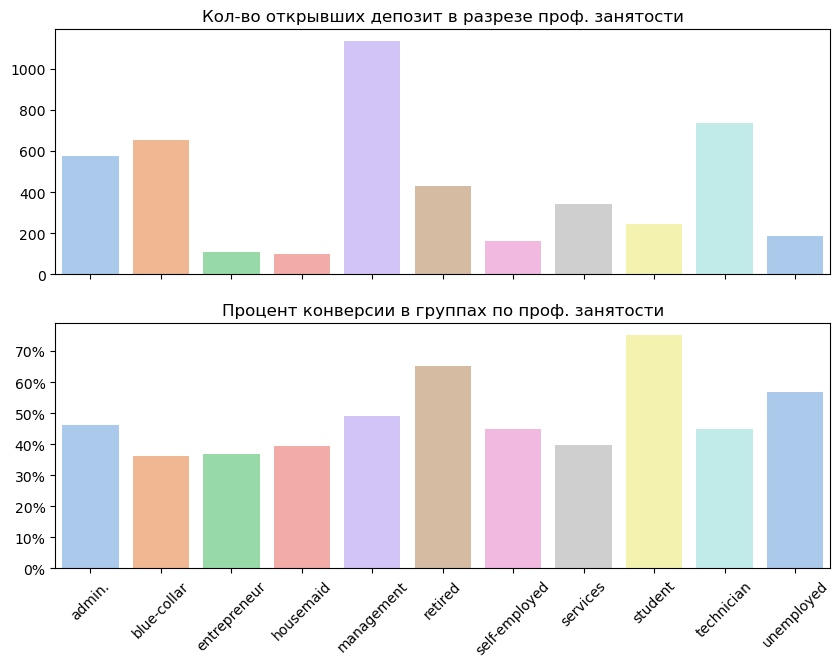

In [316]:
# постройте визуализации для открывших и неоткрывших депозит 
# в зависимости от вида профессиональной занятости

data = df.groupby('job')['deposit_flag'].agg(['sum', 'count']).reset_index()

data['conversion'] = data['sum'] / data['count']

_fig, ax = figax('by_education', rowcol=(2, 1), figsize=(10, 7))

sns.barplot(ax=ax[0], data=data, x='job', y='sum', palette='pastel');
ax[0].set_title('Кол-во открывших депозит в разрезе проф. занятости');
ax[0].set_ylabel('');
ax[0].set_xlabel('');
ax[0].set_xticklabels(['' for _label in ax[0].get_xticklabels()]);

sns.barplot(ax=ax[1], data=data, x='job', y='conversion', palette='pastel');
ax[1].set_title('Процент конверсии в группах по проф. занятости');
ax[1].set_ylabel('');
ax[1].set_yticklabels([str(x) + '%' for x in range(0, 71, 10)]);
ax[1].set_xlabel('');
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45);


### Задание 11

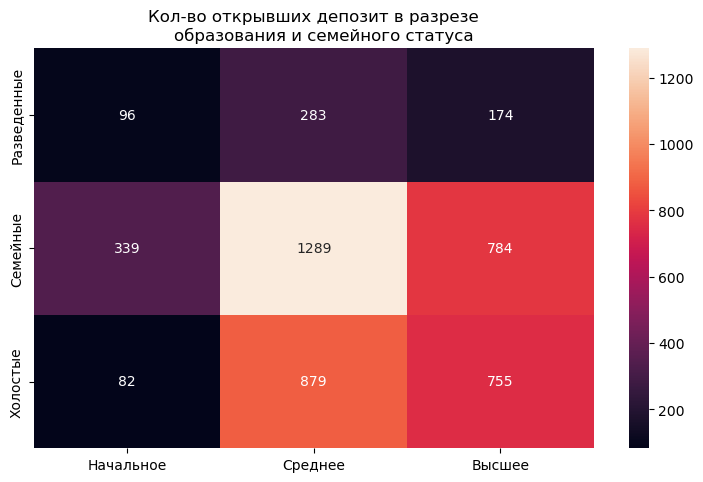

In [317]:
# постройте сводную таблицу, чтобы определить люди с каким образованием
# и семейным статусом наиболее многочисленны
# (если рассматривать тех, кто открыл депозит)

m = df['deposit'] == 'yes'

df_deposit_yes = df[m][['marital', 'education']].copy()

data_deposit_yes = pd.crosstab(df_deposit_yes['marital'], df_deposit_yes['education'])
data_deposit_yes.reset_index(inplace=True)
data_deposit_yes.set_index('marital', inplace=True)
fig, ax = figax('marital_education_cross')
sns.heatmap(ax=ax, data=data_deposit_yes, annot=True, fmt='');
title = 'Кол-во открывших депозит в разрезе\n\
    образования и семейного статуса'
ax.set_title(title);
ax.set_xlabel('');
ax.set_xticklabels(['Начальное', 'Среднее', 'Высшее']);
ax.set_ylabel('');
ax.set_yticklabels(['Разведенные', 'Семейные', 'Холостые']);

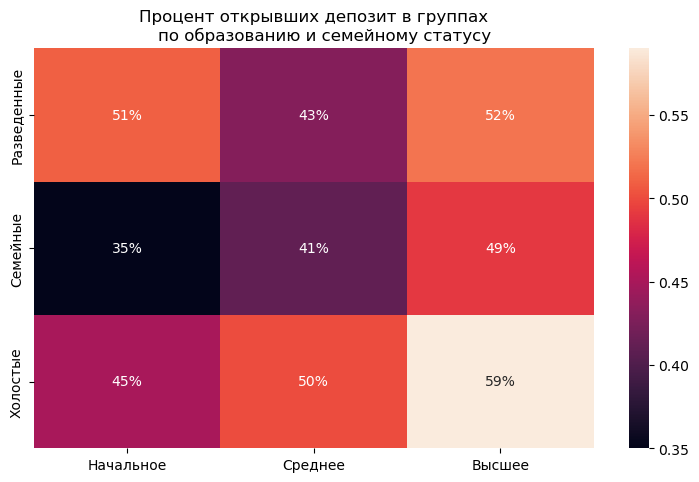

In [318]:

df_deposit_yes_no = df[['marital', 'education']].copy()

df_deposit_yes_no = pd.crosstab(df_deposit_yes_no['marital'], df_deposit_yes_no['education'])
df_deposit_yes_no.reset_index(inplace=True)
df_deposit_yes_no.set_index('marital', inplace=True)
fig, ax = figax('marital_education_cross')
data = data_deposit_yes / df_deposit_yes_no

data = data.round(2)

sns.heatmap(ax=ax, data=data, annot=True, fmt='.0%');
title = 'Процент открывших депозит в группах\n\
    по образованию и семейному статусу'
ax.set_title(title);
ax.set_xlabel('');
ax.set_xticklabels(['Начальное', 'Среднее', 'Высшее']);
ax.set_ylabel('');
ax.set_yticklabels(['Разведенные', 'Семейные', 'Холостые']);


## Часть 3: преобразование данных

### Задание 1

In [320]:
# преобразуйте уровни образования

_encoder = apply_label_encoder(df, ['education'])

df['education'].sum()

11995

### Задания 2 и 3

In [321]:
# преобразуйте бинарные переменные в представление из нулей и единиц

yes_no_columns = ['default', 'housing', 'loan', 'deposit']

for col in yes_no_columns:
    df.loc[:, col] = df[col].apply(lambda x: 1 if x == 'yes' else 0)

df.drop(columns=['deposit_flag'], inplace=True)


In [322]:
# Вычислите стандартное отклонение по преобразованной в корректный вид
# целевой переменной deposit. Ответ округлите до трёх знаков после точки-разделителя.
deposit_std = round(df['deposit'].std(), 3)
print(f'Стандартное отклонение в признаке `deposit`: {deposit_std}')

# Вычислите среднее арифметическое для каждой из получившихся переменных,
# сложите три результата и в качестве ответа впишите итог,
# округлив его до трёх знаков после точки-разделителя.
three_columns = ['default', 'housing', 'loan']
three_columns_joined = ', '.join([f'`{x}`' for x in three_columns])
three_columns_avg_sum = round(df[three_columns].mean().sum(), 3)
print(f'Сумма средних арифметических признаков\
 {three_columns_joined}:  {three_columns_avg_sum}')


Стандартное отклонение в признаке `deposit`: 0.499
Сумма средних арифметических признаков `default`, `housing`, `loan`:  0.635


### Задание 4

In [323]:
# создайте дамми-переменные

columns_to_apply_dummies = ['job', 'marital', 'contact', 'month', 'poutcome']

dummies = pd.get_dummies(df[columns_to_apply_dummies])

df.loc[:, dummies.columns] = dummies

# Сколько теперь всего признаков в датасете, не считая целевую переменную?
# Введите ответ, посчитав уже добавленные dummy-переменные,
# но до удаления номинальных.

print(f'Признаков в датасете (не считая целевого): {df.shape[1] - 1}')

Признаков в датасете (не считая целевого): 50


### Задания 5 и 6

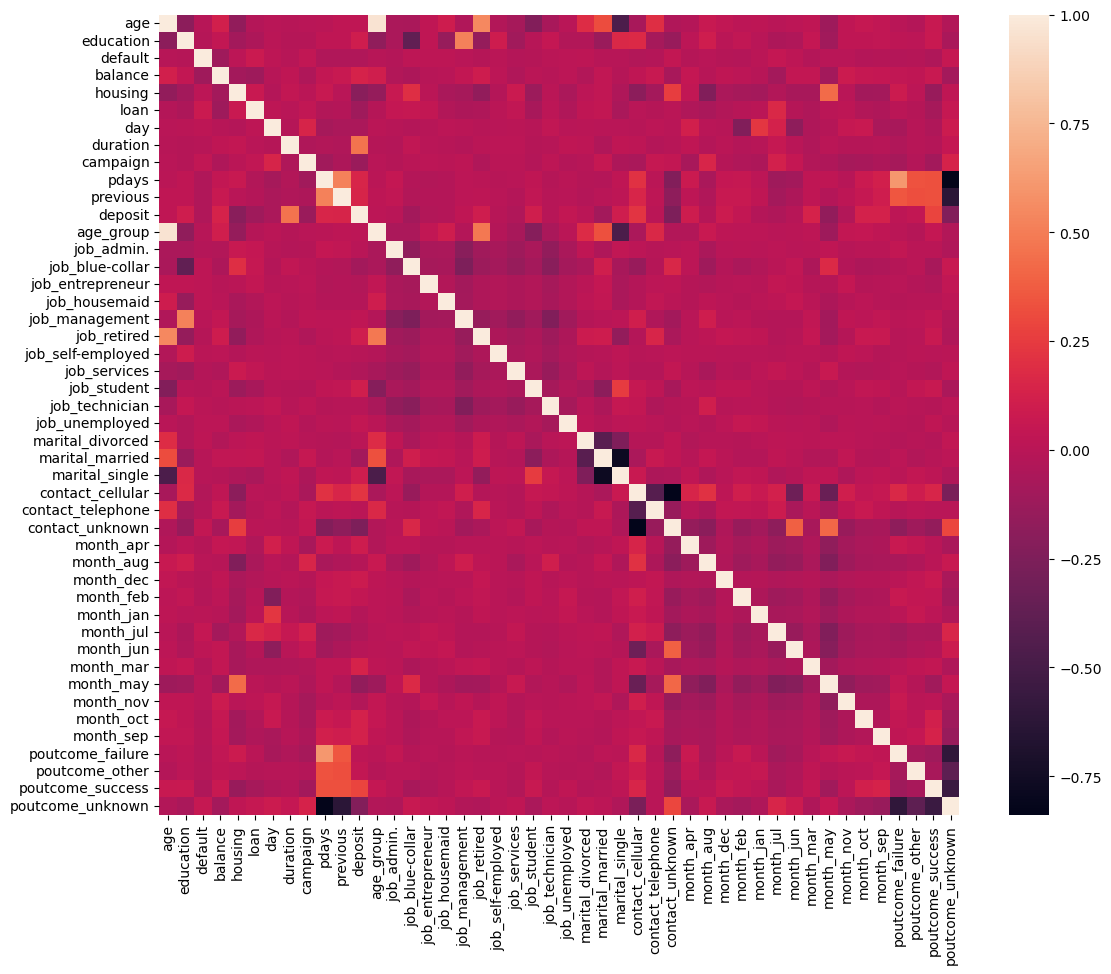

In [324]:
# постройте корреляционную матрицу и оцените данные
# на предмет наличия мультиколлинеарности

_fix, ax = figax('corr_heatmap', figsize=(10, 8))

sns.heatmap(ax=ax, data=df.corr(), annot=False, mask=None);

In [325]:
# Если достаточно сильной считать корреляцию >= 0.9,
# то есть только одна пара признаков с мультиколлинеарностью —
# `age` и `age_group`. Но нет мультиколлинеарных признаков,
# связанных с целевым.

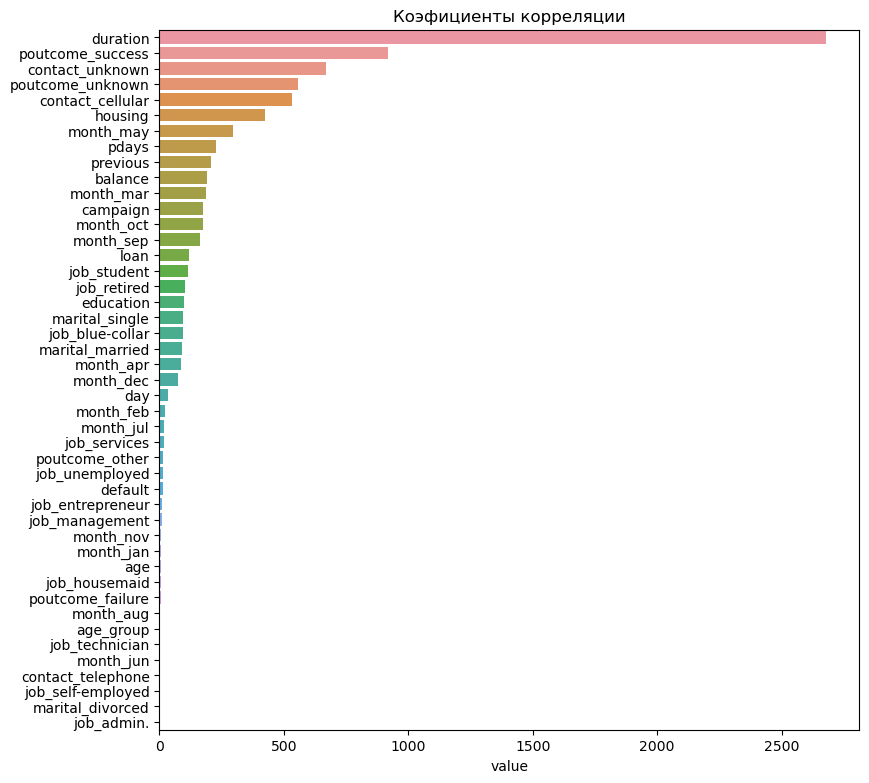

In [334]:
visualize_numeric_columns_importance(
    data=df,
    target_column='deposit',
    title='Коэфициенты корреляции',
    figsize=(7, 7)
    )

### Задания 7 и 8

In [343]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [344]:
# рассчитайте необходимые показатели

# Каким получился размер тестовой выборки?
print(f'Размер тестовой выборки: {X_test.shape[0]}')


# Каково среднее значение целевой переменной на тестовой выборке?
# Ответ округлите до двух знаков после точки-разделителя.
deposit_mean = y_test.mean()
print(f'Среднее значение целевой переменной на тестовой выборке: {round(deposit_mean, 2)}')

Размер тестовой выборки: 3335
Среднее значение целевой переменной на тестовой выборке: 0.46


### Задание 9

In [345]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

selector = SelectKBest(f_classif, k=15)
numeric_columns = X_train.select_dtypes(include='number').columns
selector.fit(X_train[numeric_columns], y_train)
best_features = selector.get_feature_names_out()

print('15 лучших признаков:')
print(*[f'  - `{x}`' for x in best_features], sep='\n')

15 лучших признаков:
  - `balance`
  - `housing`
  - `loan`
  - `duration`
  - `campaign`
  - `pdays`
  - `previous`
  - `contact_cellular`
  - `contact_unknown`
  - `month_mar`
  - `month_may`
  - `month_oct`
  - `month_sep`
  - `poutcome_success`
  - `poutcome_unknown`


In [346]:
# В моем случае 15 лучших признаков получились не такими, как на платформе.
# Возможно дело тут в различных версиях используемых модулей.
# Чтобы ответы в ноутбуке совпадали с ответами на платформе, установим
# список лучших признаков вручную.

best_features = ['balance',
    'housing',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'age_group',
    'contact_cellular',
    'contact_unknown',
    'month_mar',
    'month_may',
    'month_oct',
    'month_sep',
    'poutcome_success',
    'poutcome_unknown']

X_train = X_train[best_features]
X_test = X_test[best_features]


### Задание 10

In [347]:
# нормализуйте данные с помощью minmaxsxaler

# from sklearn import preprocessing as ce

# RobustScaler - нормализация
# MinMaxScaler - нормализация
# StandardScaler - стандартизация
# (Если разброс данных не очень большой, то можно не делать трансформацию.)
# Если данные НЕ распределены нормально, нужна нормализация,
# иначе — стандартизация

scaler = preprocessing.MinMaxScaler()
scaler.fit(X[best_features])

def normalize_data(X, scaler):
    X_transformed = X.copy()
    columns_to_scale = X_transformed.columns.to_list()
    # create scaler once and fit it to some initial data

    # use the scaler for data (once or many times)
    ndarr = scaler.transform(X_transformed[columns_to_scale])
    # create a DataFrame out of ndarr
    norm_df = pd.DataFrame(ndarr, columns=columns_to_scale).set_index(X_transformed.index)
    # update the transformed columns data
    X.loc[:, columns_to_scale] = norm_df[columns_to_scale]

normalize_data(X_train, scaler)
normalize_data(X_test, scaler)

# Рассчитайте среднее арифметическое для первого предиктора
# (т. е. для первого столбца матрицы) из тестовой выборки.
# Ответ округлите до двух знаков после точки-разделителя.

first_column = X_test.columns[0]
first_column_mean = X_test[first_column].mean()

print(f'Среднее арифметическое первого предиктера: {round(first_column_mean, 2)}')

Среднее арифметическое первого предиктера: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [350]:
# обучите логистическую регрессию и рассчитайте метрики качества

log_reg = linear_model.LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='sag', # численный метод оптимизации функции потерь
)

log_reg.fit(X_train, y_train)

# Для получившейся модели вычислите значение accuracy на тестовой выборке.
# Ответ округлите до двух знаков после точки-разделителя.

y_test_pred = log_reg.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred);

print(f'Accuracy: {round(test_accuracy, 2)}')


Accuracy: 0.8


### Задания 2,3,4

In [351]:
# обучите решающие деревья, настройте максимальную глубину

dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
)

dt_clf.fit(X_train, y_train);

y_test_pred = dt_clf.predict(X_test);
print(f'F₁ score for X_test: {metrics.f1_score(y_test, y_test_pred)}')

y_train_pred = dt_clf.predict(X_train);
print(f'F₁ score for X_train: {metrics.f1_score(y_train, y_train_pred)}')

F₁ score for X_test: 0.7272727272727273
F₁ score for X_train: 1.0


In [352]:
# Переберите различные максимальные глубины деревьев и найдите глубину дерева, 
# для которой будет максимальное значение метрики accuracy, 
# но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти 
# качество на обучающей выборке при неизменном качестве на тестовой).

# from sklearn import tree
# criterion — критерий информативности ('gini' — критерий Джини и 'entropy' — энтропия Шеннона).
# max_depth — максимальная глубина дерева (по умолчанию — None, глубина дерева не ограничена).
# max_features — максимальное число признаков, по которым ищется лучшее разбиение в дереве (по умолчанию — None, то есть обучение производится на всех признаках). Нужно потому, что при большом количестве признаков будет «дорого» искать лучшее (по критерию типа прироста информации) разбиение среди всех признаков.
# min_samples_leaf — минимальное число объектов в листе (по умолчанию — 1). У этого параметра есть понятная интерпретация: если он равен 5, то дерево будет порождать только те решающие правила, которые верны как минимум для пяти объектов.
# random_state — число, отвечающее за генерацию случайных чисел.

def train_and_estimate_dt(max_depth):
    dt_clf = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth=max_depth,
        random_state=42,
    )

    dt_clf.fit(X_train, y_train);
    y_test_pred = dt_clf.predict(X_test);
    y_train_pred = dt_clf.predict(X_train);

    print(f'\nFor max_depth={max_depth}:')
    print(f'- F₁ score for X_test: {metrics.f1_score(y_test, y_test_pred)}')
    print(f'- F₁ score for X_train: {metrics.f1_score(y_train, y_train_pred)}')
    print(f'- Accuracy for X_test: {metrics.accuracy_score(y_test, y_test_pred)}')

for max_depth in range(1, 20):
    train_and_estimate_dt(max_depth)



For max_depth=1:
- F₁ score for X_test: 0.7194038406420178
- F₁ score for X_train: 0.728712321155716
- Accuracy for X_test: 0.7064467766116942

For max_depth=2:
- F₁ score for X_test: 0.6379376683339746
- F₁ score for X_train: 0.6466512702078522
- Accuracy for X_test: 0.7178410794602699

For max_depth=3:
- F₁ score for X_test: 0.7760233918128655
- F₁ score for X_train: 0.7822094691535151
- Accuracy for X_test: 0.7703148425787106

For max_depth=4:
- F₁ score for X_test: 0.7757965507161649
- F₁ score for X_train: 0.7823841629608378
- Accuracy for X_test: 0.7700149925037482

For max_depth=5:
- F₁ score for X_test: 0.7821122740247383
- F₁ score for X_train: 0.7937247592420006
- Accuracy for X_test: 0.7940029985007496

For max_depth=6:
- F₁ score for X_test: 0.7865384615384615
- F₁ score for X_train: 0.7995601633678919
- Accuracy for X_test: 0.8002998500749625

For max_depth=7:
- F₁ score for X_test: 0.7842227378190255
- F₁ score for X_train: 0.8063885267275098
- Accuracy for X_test: 0.804

### Задание 5

In [353]:
# подберите оптимальные параметры с помощью gridsearch

param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3,5,7],
}

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        # неизменяемые параметры
        criterion='entropy',
        random_state=42,
    ),
    param_grid=param_grid,
)

grid_search.fit(X_train, y_train)

# наилучшая комбинация гиперпараметров
print(grid_search.best_params_)

# метрика на тестовой выборке
print(grid_search.score(X_test, y_test))

# Оцените метрику  на тестовой выборке для наилучшей комбинации перебираемых параметров. 
# В качестве ответа впишите значение метрики. Ответ округлите до двух знаков после точки-разделителя.
y_test_pred = grid_search.predict(X_test)
f1_test = metrics.f1_score(y_test, y_test_pred)

print(f'F₁ score for X_test: {round(f1_test, 2)}')

{'max_depth': 7, 'min_samples_split': 5}
0.8038980509745127
F₁ score for X_test: 0.78


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [354]:
# обучите на ваших данных случайный лес

rf_clf = ensemble.RandomForestClassifier(
    n_estimators=100, # число деревьев
    criterion='gini',
    max_depth=10,
    min_samples_leaf=5,
    random_state=42
)

rf_clf.fit(X_train, y_train)

y_test_pred = rf_clf.predict(X_test)

# Оцените метрики accuracy и recall для построенной модели на тестовой выборке. 
# В качестве ответов введите значения метрик. Ответ округлите до двух знаков после точки-разделителя.

# from sklearn import metrics
# import seaborn as sns

accuracy = metrics.accuracy_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)

print(f'Accuracy: {round(accuracy, 2)}')
print(f'Recall: {round(recall, 2)}')


Accuracy: 0.83
Recall: 0.83


### Задания 2 и 3

In [368]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

gbr = ensemble.GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42,
)

gbr.fit(X_train, y_train);

# Для построенной модели оцените метрику F1 на тестовой выборке.
# В качестве ответа впишите значение метрики.
# Ответ округлите до двух знаков после точки-разделителя.

f1 = metrics.f1_score(y_test, gbr.predict(X_test))
print(f'F₁ score: {f1}')


F₁ score: 0.8146031746031746


### Задание 4

In [369]:
# объедините уже известные вам алгоритмы с помощью стекинга 

# список базовых моделей
log_reg = linear_model.LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='sag',
)

dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=7,
    min_samples_split=5,
)

gbr = ensemble.GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42,
)

estimators = [
    ('log_reg', log_reg),
    ('dt_clf', dt_clf),
    ('gbr', gbr),
]

# метамодель
final_estimator = linear_model.LogisticRegression(
    random_state=42
)

# объект класса стекинг
reg = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
)

reg.fit(X_train, y_train);


In [371]:
# Для построенной модели оцените метрику precision на тестовой выборке.
# В качестве ответа впишите значение метрики. Ответ округлите
# до двух знаков после точки-разделителя.

y_test_pred = reg.predict(X_test)

precision = metrics.precision_score(y_test, y_test_pred)

print(f'Precision: {round(precision, 2)}')


Precision: 0.81


### Задание 5

In [402]:
# оцените, какие признаки демонстрируют наибольшую  важность 
# в модели градиентного бустинга

def find_K_best_with_RFE(X, y, estimator, k):
    selector = RFE(estimator, step=1, n_features_to_select=k)
    selector = selector.fit(X_train, y_train)
    return selector.get_feature_names_out()

estimator = ensemble.GradientBoostingClassifier()
features_counter = Counter([])

# Для экономии времени посчитаем только первые пять
for k in range(1, 6):
    best_features = find_K_best_with_RFE(X_train, y_train, estimator, k)
    features_counter.update(best_features)

features_by_importance = features_counter.most_common()
feature_names_by_importance = [x[0] for x in features_by_importance]

print('Признаки по важности для модели градиентного бустинга')
print(*[f'- `{x}`' for x in feature_names_by_importance], sep='\n')



Признаки по важности для модели градиентного бустинга
- `duration`
- `poutcome_success`
- `contact_unknown`
- `pdays`
- `housing`


In [414]:
# Есть еще один способ — воспользоваться свойством `feature_importances_` модели

gbr = ensemble.GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42,
);

gbr.fit(X_train, y_train)

features_with_imporance = [(col, imp) for (col, imp) in zip(X_train.columns, gbr.feature_importances_)]
features_with_imporance_sorted = sorted(features_with_imporance, key=lambda x: x[1], reverse=True)

print('Признаки по важности для модели градиентного бустинга')
print(*[f'- `{x[0]}`' for x in features_with_imporance_sorted], sep='\n')


Признаки по важности для модели градиентного бустинга
- `duration`
- `poutcome_success`
- `contact_unknown`
- `balance`
- `pdays`
- `housing`
- `age_group`
- `month_mar`
- `month_oct`
- `campaign`
- `month_may`
- `month_sep`
- `previous`
- `contact_cellular`
- `poutcome_unknown`


### Задания 6,7,8

In [422]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

def calc_log_res_params(all_params):
    n_estimators = all_params['n_estimators']
    max_depth = all_params['max_depth']
    min_samples_leaf = all_params['min_samples_leaf']

    res_params = {
        'criterion': 'gini',
        'random_state': 42,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf,
    }

    return res_params

def optuna_rf_log_reg(trial):
    # задаем пространство поиска
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # динамически вычисляем параметры
    res_params = calc_log_res_params({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_leaf': min_samples_leaf,
    })

    # создае модель
    rf_clf = ensemble.RandomForestClassifier(**res_params)

    # обучаем модель с помощью кросс-валидации
    score = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()

    return score

# создаем процесс обучения и запускаем его
study = optuna.create_study(study_name='Optuna: Logistic regression', direction='maximize')

study.optimize(optuna_rf_log_reg, n_trials=15)

# при необходимости выполняем дополнтиельные итерации
# study.optimize(optuna_rf_log_reg, n_trials=10)

print('Наилучшие значения гиперпараметров')
print(study.best_params)

[I 2023-04-16 18:23:55,207] A new study created in memory with name: Optuna: Logistic regression
[I 2023-04-16 18:23:55,746] Trial 0 finished with value: 0.8260745159998788 and parameters: {'n_estimators': 185, 'max_depth': 14, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8260745159998788.
[I 2023-04-16 18:23:56,156] Trial 1 finished with value: 0.8278752695856294 and parameters: {'n_estimators': 138, 'max_depth': 15, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8278752695856294.
[I 2023-04-16 18:23:56,634] Trial 2 finished with value: 0.8269757726523842 and parameters: {'n_estimators': 158, 'max_depth': 21, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8278752695856294.
[I 2023-04-16 18:23:57,104] Trial 3 finished with value: 0.8240793083148 and parameters: {'n_estimators': 182, 'max_depth': 27, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8278752695856294.
[I 2023-04-16 18:23:57,613] Trial 4 finished with value: 0.8251724382442072 and parameters: {'

Наилучшие значения гиперпараметров
{'n_estimators': 100, 'max_depth': 12, 'min_samples_leaf': 3}


In [425]:
# Введите значение метрики F1 на тестовой выборке.
# Ответ округлите до двух знаков после точки-разделителя.

rf_clf = ensemble.RandomForestClassifier(**calc_log_res_params(study.best_params))
rf_clf.fit(X_train, y_train)

y_test_pred = rf_clf.predict(X_test)
f1 = metrics.f1_score(y_test, y_test_pred)

print(f'F₁ score: {round(f1, 2)}')

F₁ score: 0.82


In [426]:
# Введите значение метрики accuracy на тестовой выборке.
# Ответ округлите до двух знаков после точки-разделителя.

y_test_pred = rf_clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_test_pred)

print(f'Accuracy: {round(accuracy, 2)}')

Accuracy: 0.83
